<a href="https://colab.research.google.com/github/Nish-hub94/AppliedMLProject/blob/main/AML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# **Data loading**

In [ ]:
df = pd.read_csv("/content/industrial_fault_detection_data_1000.csv")

# **Basic information**

In [ ]:
df.describe()

,Vibration (mm/s),Temperature (°C),Pressure (bar),RMS Vibration,Mean Temp,Fault Label
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,0.541231,90.561384,8.507217,6.016565e-01,9.056138e+01,0.479000
std,0.262924,23.375191,0.872023,1.110779e-14,7.108983e-13,0.652675
min,0.104169,50.257461,7.000035,6.016565e-01,9.056138e+01,0.000000
25%,0.312376,69.285942,7.784053,6.016565e-01,9.056138e+01,0.000000
50%,0.547127,91.498713,8.501842,6.016565e-01,9.056138e+01,0.000000
75%,0.769888,110.837205,9.277311,6.016565e-01,9.056138e+01,1.000000
max,0.999746,129.953098,9.993463,6.016565e-01,9.056138e+01,2.000000


In [ ]:
df.head()

,Timestamp,Vibration (mm/s),Temperature (°C),Pressure (bar),RMS Vibration,Mean Temp,Fault Label
0,2023-03-10 00:00:00,0.437086,64.810634,7.785117,0.601657,90.561384,1
1,2023-03-10 00:01:00,0.955643,93.352076,7.740936,0.601657,90.561384,1
2,2023-03-10 00:02:00,0.758795,119.835667,9.718764,0.601657,90.561384,0
3,2023-03-10 00:03:00,0.638793,108.577991,7.748639,0.601657,90.561384,1
4,2023-03-10 00:04:00,0.240417,114.524892,7.815849,0.601657,90.561384,0


In [ ]:
print(df.columns)

Index(['Timestamp', 'Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)',
       'RMS Vibration', 'Mean Temp', 'Fault Label'],
      dtype='object')


In [ ]:
print(df.shape)

(1000, 7)


In [ ]:
df.isnull().values.any()

np.False_

In [ ]:
df.isnull().sum()

,0
Timestamp,0
Vibration (mm/s),0
Temperature (°C),0
Pressure (bar),0
RMS Vibration,0
Mean Temp,0
Fault Label,0


In [ ]:
print(df['Fault Label'].value_counts())

Fault Label
0    609
1    303
2     88
Name: count, dtype: int64


In [ ]:
#Map numeric labels to descriptive names
label_mapping = {0: 'No Fault', 1: 'Bearing Fault', 2: 'Overheating'}
df['Fault Type'] = df['Fault Label'].map(label_mapping)

#Count each type
counts = df['Fault Type'].value_counts()
print(counts)



Fault Type
No Fault         609
Bearing Fault    303
Overheating       88
Name: count, dtype: int64


/tmp/ipython-input-309460351.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Fault Type', palette='coolwarm')


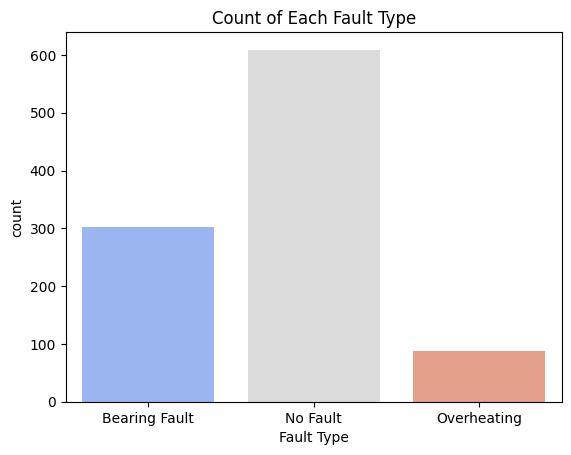

In [ ]:
sns.countplot(data=df, x='Fault Type', palette='coolwarm')
plt.title('Count of Each Fault Type')
plt.show()

In [ ]:
feature_cols = ['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)', 'RMS Vibration', 'Mean Temp']
pair_df = df[feature_cols + ['Fault Label']]

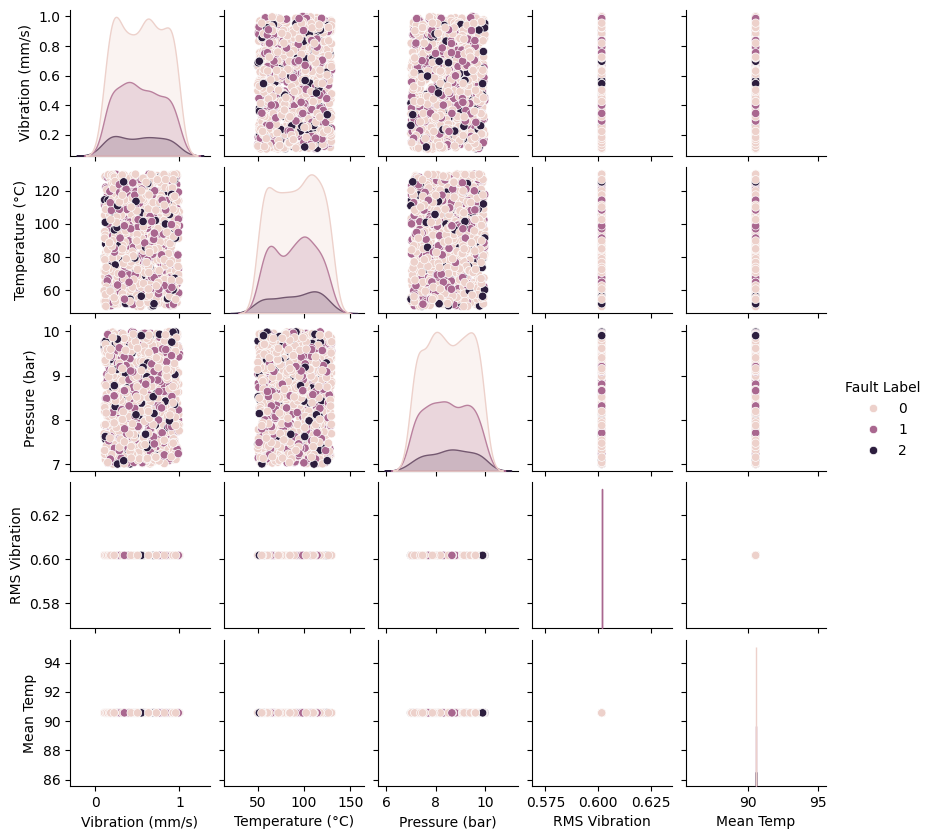

In [ ]:
sns.pairplot(pair_df, hue='Fault Label',diag_kind='kde', height=1.7)

plt.show()

# **Preprocessing**

Seperating features and labels

In [ ]:
X = df[feature_cols].values
y = df['Fault Label'].values

In [ ]:
print(X)

[[  0.43708611  64.81063431   7.78511705   0.60165654  90.56138441]
 [  0.95564288  93.35207579   7.7409364    0.60165654  90.56138441]
 [  0.75879455 119.83566687   9.71876374   0.60165654  90.56138441]
 ...
 [  0.22313677  55.51664131   7.92936358   0.60165654  90.56138441]
 [  0.95521362  54.56437769   7.8701366    0.60165654  90.56138441]
 [  0.5014052   72.57496598   9.6142421    0.60165654  90.56138441]]


In [ ]:
print(y)

[1 1 0 1 0 1 2 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 2 1 1 1 0 0 1 0 0 0 0
 2 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 1 2 1 0 0 2 0 0 0 1 1 0 0 2 0 1 1 1 0 0
 0 1 2 0 0 2 1 1 0 0 1 1 0 0 0 0 0 2 0 1 0 1 2 0 0 0 0 1 2 0 0 0 1 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 2 1 1 1 2 0 0 1 1 1 0 0 0 2 0 0 0 0 1 1
 1 0 1 0 1 0 0 1 2 0 1 0 0 0 0 0 0 0 2 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 2 2 0 0 0 2 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 2 0 0 1 0 0 2 0
 1 0 0 1 0 2 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0
 0 1 1 2 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 2 0 0 0 1 0 1 1 1 0 1 0 2 1 0 0 0 1
 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 2 2 1 1 0 0 0 0 2 0 1 1 1
 2 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 2 1 0 1 0 0 0 2 2 0 0 0 2
 2 1 1 1 0 0 0 1 1 0 2 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 2 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 1 1 

**Split first (to prevent data leakage)**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
scaler = StandardScaler()

In [ ]:
# X_train_scaled is the standardized version of the training data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)